# Outline
1. preprocesing
    1. standardization
    1. one-hot encoding
1. Modeling
    1. LinerModel
        - Ridge
        - Lasso
    1. SVR
    1. Tree model
        - GBDT (LightGBM)
        - RandomForest 
1. Tuning of each model hyperparameter
1. Stacking
1. Ensemble

# 0.Module

In [35]:
import os
import datetime
from copy import deepcopy
from typing import Tuple, Union
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn.linear_model import LassoCV, RidgeCV, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold, SequentialFeatureSelector
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_is_fitted
import lightgbm as lgb
from xgboost import XGBRegressor, plot_importance
# from lightgbm import log
from EDA import EDA
pd.options.display.precision = 2
np.set_printoptions(precision=4)

def RMSE(y_true: np.ndarray, y_pred: np.ndarray) -> np.float64:
    return np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred))

def train_and_valied(model: BaseEstimator, X_train: pd.DataFrame=None, y_train: pd.Series=None,
                         X_test: pd.DataFrame=None, y_test: pd.Series=None, scoring: str="RMSE", aditional_kwargs: dict={}) -> BaseEstimator:
    model.fit(X=X_train, y=y_train, **aditional_kwargs)
    y_pred = model.predict(X=X_test)
    # print(f"y_pred={y_pred}")
    if scoring=="RMSE":
        score = RMSE(y_true=y_test, y_pred=y_pred)
    
    print(f"{scoring} : {score:.4f}")

    return model

def make_stacking_feature(model: BaseEstimator, X_train: pd.DataFrame=None, y_train: pd.Series=None, X_test: pd.DataFrame=None, 
                cv: int=5, model_name: str="", fit_params: dict={}) -> Tuple[pd.Series, pd.Series]:

    cv_spliter = KFold(n_splits=cv)
    preds_train = []
    preds_test = []
    ids = []

    # out-of-holdで学習と予測を行う。
    # 例：4分割して上から順に第1セクション...第4セクションとすると、
    # 1回目のループでは2～4セクションで学習し、第一セクション対する予測を行い2層名の特徴量とする。
    # さらに、2~4セクションで学習したモデルでテストデータに対する予測も行う。
    # これをセクション分ループし、1層目のモデルによる特徴量と予測値を作る。
    for train_id, test_id in cv_spliter.split(X_train):
        X_tr, X_vd = X_train.iloc[train_id, :], X_train.iloc[test_id, :]
        y_tr, y_vd = y_train.iloc[train_id], y_train.iloc[test_id]
        model.fit(X_tr, y_tr, **fit_params)
        preds_train.append(model.predict(X_vd).reshape(-1, 1))
        preds_test.append(model.predict(X_test).reshape(-1, 1))
        ids.append(test_id)

    # 訓練データに対する予測を結合する+テストデータに対する予測の平均を取る
    ids = np.concatenate(ids)
    preds_train = np.concatenate(preds_train, axis=0)
    # print(f"preds_train.shape: {preds_train.shape}")
    preds_train = pd.DataFrame(preds_train, index=ids, columns=[model_name]).sort_index()
    preds_test = np.concatenate(preds_test, axis=1).mean(axis=1)
    # print(f"preds_test.shape: {preds_test.shape}")
    preds_test = pd.DataFrame(preds_test, index=X_test.index, columns=[model_name])

    return preds_train, preds_test

def stacking(first_layer_models: dict, second_lyaer_models: dict, X_train: pd.DataFrame=None, 
                y_train: pd.Series=None, X_test: pd.DataFrame=None, y_test: pd.Series=None, cv: int=5):
                
    """
    2層のスタッキングを行う。

    以下のように"model_name"がキーと、[モデルインスタンス, フィッティングパラメータ]がvalueのdictを渡す。

    first_layer_models = {
        "Lasso": [Lasso(), lasso_fit_params],
        "SVR": [SVR(), svr_fit_params],
        "RandomForest": [RandomForestRegressor(), randomforest_fit_params]
    }

    second_layer_models = {
        "Ridge": [Ridge(), ridge_fit_params],
    }
    """

    # preds_train: 2層目の訓練データの特徴量
    # preds_test: 2層目のテストデータの特徴量

    for i, (key, value) in enumerate(first_layer_models.items()):
        print(f"first_layer model_{i} -> {key}")
        if i == 0:
            preds_train, preds_test = make_stacking_feature(model=value[0], X_train=X_train,
                                                             y_train=y_train, X_test=X_test, cv=cv, model_name=key, fit_params=value[1])

        else:
            temp_train, temp_test = make_stacking_feature(model=value[0], X_train=X_train,
                                                             y_train=y_train, X_test=X_test, cv=cv, model_name=key, fit_params=value[1])
            preds_train = pd.concat([preds_train, temp_train], axis=1)
            preds_test = pd.concat([preds_test, temp_test], axis=1)
        print(f"{key}: RMSE -> {RMSE(y_true=y_train, y_pred=preds_train if i==0 else temp_train):.3f}\n")
    
    # display(preds_train.head(5), preds_test.head(5))
    for model_name, models in second_lyaer_models.items(): 
        print(f"second_layer model -> {model_name}")
        model, fit_param = models[0], models[1]
        second_lyaer_model = train_and_valied(model=model, X_train=preds_train, y_train=y_train,
                                            X_test=preds_test, y_test=y_test, scoring="RMSE",
                                            aditional_kwargs=fit_param)

class Blender(BaseEstimator, RegressorMixin):

    def __init__(self, blending_models: dict, blendig_rates: list) -> None:
        super().__init__()

        if len(blending_models) != len(blendig_rates):
            raise ValueError("length of blending_models and blending_rates must be equal!")

        if sum(blendig_rates) != 1.:
            raise ValueError("sum of blending_rates must be 1.0")

        self.blending_models = blending_models
        self.blendig_rates = blendig_rates
        # self.fited_models = {}

    def fit(self, X, y):

        for name, model_inst_and_param in self.blending_models.items():
            print(f"fit {name}")
            model_inst_and_param[0].fit(X, y, **model_inst_and_param[1])
        
        return self

    def predict(self, X) -> np.ndarray:
        y_pred = 0
        for i, model_inst_and_param in enumerate(self.blending_models.values()):
            y_pred +=  self.blendig_rates[i] * (model_inst_and_param[0].predict(X))
        
        return y_pred

In [12]:
a = np.arange(10)
b = np.arange(10) *3
c = dict(zip(a, b))
print(c, len(c))
for value in c.values():
    print(value)

{0: 0, 1: 3, 2: 6, 3: 9, 4: 12, 5: 15, 6: 18, 7: 21, 8: 24, 9: 27} 10
0
3
6
9
12
15
18
21
24
27


# 1.preprocessing

In [29]:
train_data_raw = EDA(pd.read_csv("./data/train.csv", index_col=0, decimal=","))
train_data = EDA(pd.read_csv("./data/train_after_EDA.csv", index_col=0, decimal=","))
test_data = EDA(pd.read_csv("./data/test_after_EDA.csv", index_col=0, decimal=","))

# なぜか文字列として読み込まれてしまう特徴量を型変換
after = set(train_data.categorical_feature.columns)
before = set(train_data_raw.categorical_feature.columns)
diff_feature = after-before
for name in diff_feature:
    if name == "SalePrice":
        train_data.data[name] = train_data.data[name].astype(float)
    else:
        train_data.data[name] = train_data.data[name].astype(float)
        test_data.data[name] = test_data.data[name].astype(float)


X = deepcopy(train_data.data.drop('SalePrice', axis=1))
X['datatype'] = "train"
temp = deepcopy(test_data.data)
temp['datatype'] = "test"
X_all = pd.concat([X, temp])
y = train_data.data['SalePrice']
train_data.data = X.drop('datatype', axis=1)
train_data.set_categorical_and_numerical_feature()
test_data.set_categorical_and_numerical_feature()
train_data_raw.set_categorical_and_numerical_feature()

display(train_data.data, test_data.data, X_all)

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,QualSF,TotalBath,meanRmsSF
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,4.19,9.04,NaN,Reg,Lvl,Inside,Gtl,CollgCr,...,NaN,NaN,0,2,2008,WD,Normal,9.80,3.5,5.37
2,20,RL,4.39,9.17,NaN,Reg,Lvl,FR2,Gtl,Veenker,...,NaN,NaN,0,5,2007,WD,Normal,9.63,2.5,5.35
3,60,RL,4.23,9.33,NaN,IR1,Lvl,Inside,Gtl,CollgCr,...,NaN,NaN,0,9,2008,WD,Normal,9.85,3.5,5.70
4,70,RL,4.11,9.16,NaN,IR1,Lvl,Corner,Gtl,Crawfor,...,NaN,NaN,0,2,2006,WD,Abnorml,9.76,2.0,5.51
5,60,RL,4.44,9.57,NaN,IR1,Lvl,FR2,Gtl,NoRidge,...,NaN,NaN,0,12,2008,WD,Normal,10.19,3.5,5.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,4.14,8.98,NaN,Reg,Lvl,Inside,Gtl,Gilbert,...,NaN,NaN,0,8,2007,WD,Normal,9.66,2.5,5.47
1457,20,RL,4.45,9.49,NaN,Reg,Lvl,Inside,Gtl,NWAmes,...,MnPrv,NaN,0,2,2010,WD,Normal,9.98,3.0,5.69
1458,70,RL,4.20,9.11,NaN,Reg,Lvl,Inside,Gtl,Crawfor,...,GdPrv,Shed,2500,5,2010,WD,Normal,10.10,2.0,5.56


,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,QualSF,TotalBath,meanRmsSF
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,4.39,9.36,NaN,Reg,Lvl,Inside,Gtl,NAmes,...,MnPrv,NaN,0,6,2010,WD,Normal,9.09,1.0,5.19
1462,20,RL,4.41,9.57,NaN,IR1,Lvl,Corner,Gtl,NAmes,...,NaN,Gar2,12500,6,2010,WD,Normal,9.68,1.5,5.40
1463,60,RL,4.32,9.53,NaN,IR1,Lvl,Inside,Gtl,Gilbert,...,MnPrv,NaN,0,3,2010,WD,Normal,9.46,2.5,5.61
1464,60,RL,4.37,9.21,NaN,IR1,Lvl,Inside,Gtl,Gilbert,...,NaN,NaN,0,6,2010,WD,Normal,9.63,2.5,5.44
1465,120,RL,3.78,8.52,NaN,IR1,HLS,Inside,Gtl,StoneBr,...,NaN,NaN,0,1,2010,WD,Normal,9.93,2.0,5.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,RM,3.09,7.57,NaN,Reg,Lvl,Inside,Gtl,MeadowV,...,NaN,NaN,0,6,2006,WD,Normal,8.79,1.5,5.39
2916,160,RM,3.09,7.55,NaN,Reg,Lvl,Inside,Gtl,MeadowV,...,NaN,NaN,0,4,2006,WD,Abnorml,8.79,1.5,5.21
2917,20,RL,5.08,9.90,NaN,Reg,Lvl,Inside,Gtl,Mitchel,...,NaN,NaN,0,9,2006,WD,Abnorml,9.41,2.0,5.17


,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,...,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,QualSF,TotalBath,meanRmsSF,datatype
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,4.19,9.04,NaN,Reg,Lvl,Inside,Gtl,CollgCr,...,NaN,0,2,2008,WD,Normal,9.80,3.5,5.37,train
2,20,RL,4.39,9.17,NaN,Reg,Lvl,FR2,Gtl,Veenker,...,NaN,0,5,2007,WD,Normal,9.63,2.5,5.35,train
3,60,RL,4.23,9.33,NaN,IR1,Lvl,Inside,Gtl,CollgCr,...,NaN,0,9,2008,WD,Normal,9.85,3.5,5.70,train
4,70,RL,4.11,9.16,NaN,IR1,Lvl,Corner,Gtl,Crawfor,...,NaN,0,2,2006,WD,Abnorml,9.76,2.0,5.51,train
5,60,RL,4.44,9.57,NaN,IR1,Lvl,FR2,Gtl,NoRidge,...,NaN,0,12,2008,WD,Normal,10.19,3.5,5.50,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,RM,3.09,7.57,NaN,Reg,Lvl,Inside,Gtl,MeadowV,...,NaN,0,6,2006,WD,Normal,8.79,1.5,5.39,test
2916,160,RM,3.09,7.55,NaN,Reg,Lvl,Inside,Gtl,MeadowV,...,NaN,0,4,2006,WD,Abnorml,8.79,1.5,5.21,test
2917,20,RL,5.08,9.90,NaN,Reg,Lvl,Inside,Gtl,Mitchel,...,NaN,0,9,2006,WD,Abnorml,9.41,2.0,5.17,test


## 1.1One-Hot encoding

In [30]:
categorical = train_data.categorical_feature.columns
X_all = pd.get_dummies(data=X_all, columns=categorical, drop_first=True)
train = X_all.loc[X_all["datatype"]=="train", :].drop("datatype", axis=1)
test = X_all.loc[X_all["datatype"]=="test", :].drop("datatype", axis=1)
display(X_all, train, test)

,MSSubClass,LotFrontage,LotArea,OverallCond,YearRemodAdd,MasVnrArea,ExterCond,BsmtCond,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,60,4.19,9.04,5,2003,196.0,3,3,706,0,...,0,0,0,0,1,0,0,0,1,0
2,20,4.39,9.17,8,1976,0.0,3,3,978,0,...,0,0,0,0,1,0,0,0,1,0
3,60,4.23,9.33,5,2002,162.0,3,3,486,0,...,0,0,0,0,1,0,0,0,1,0
4,70,4.11,9.16,5,1970,0.0,3,4,216,0,...,0,0,0,0,1,0,0,0,0,0
5,60,4.44,9.57,5,2000,350.0,3,3,655,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,3.09,7.57,7,1970,0.0,3,3,0.0,0.0,...,0,0,0,0,1,0,0,0,1,0
2916,160,3.09,7.55,5,1970,0.0,3,3,252.0,0.0,...,0,0,0,0,1,0,0,0,0,0
2917,20,5.08,9.90,7,1996,0.0,3,3,1224.0,0.0,...,0,0,0,0,1,0,0,0,0,0


,MSSubClass,LotFrontage,LotArea,OverallCond,YearRemodAdd,MasVnrArea,ExterCond,BsmtCond,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,60,4.19,9.04,5,2003,196.0,3,3,706,0,...,0,0,0,0,1,0,0,0,1,0
2,20,4.39,9.17,8,1976,0.0,3,3,978,0,...,0,0,0,0,1,0,0,0,1,0
3,60,4.23,9.33,5,2002,162.0,3,3,486,0,...,0,0,0,0,1,0,0,0,1,0
4,70,4.11,9.16,5,1970,0.0,3,4,216,0,...,0,0,0,0,1,0,0,0,0,0
5,60,4.44,9.57,5,2000,350.0,3,3,655,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,4.14,8.98,5,2000,0.0,3,3,0,0,...,0,0,0,0,1,0,0,0,1,0
1457,20,4.45,9.49,6,1988,119.0,3,3,790,163,...,0,0,0,0,1,0,0,0,1,0
1458,70,4.20,9.11,9,2006,0.0,4,4,275,0,...,0,0,0,0,1,0,0,0,1,0


,MSSubClass,LotFrontage,LotArea,OverallCond,YearRemodAdd,MasVnrArea,ExterCond,BsmtCond,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,4.39,9.36,6,1961,0.0,3,3,468.0,144.0,...,0,0,0,0,1,0,0,0,1,0
1462,20,4.41,9.57,6,1958,108.0,3,3,923.0,0.0,...,0,0,0,0,1,0,0,0,1,0
1463,60,4.32,9.53,5,1998,0.0,3,3,791.0,0.0,...,0,0,0,0,1,0,0,0,1,0
1464,60,4.37,9.21,6,1998,20.0,3,3,602.0,0.0,...,0,0,0,0,1,0,0,0,1,0
1465,120,3.78,8.52,5,1992,0.0,3,3,263.0,0.0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,3.09,7.57,7,1970,0.0,3,3,0.0,0.0,...,0,0,0,0,1,0,0,0,1,0
2916,160,3.09,7.55,5,1970,0.0,3,3,252.0,0.0,...,0,0,0,0,1,0,0,0,0,0
2917,20,5.08,9.90,7,1996,0.0,3,3,1224.0,0.0,...,0,0,0,0,1,0,0,0,0,0


## 1.2.standardization

In [6]:
X_train, X_valied, y_train, y_valied = train_test_split(train, y, test_size=0.2, random_state=42)
X_test = test
print(f"X_train.shape->{X_train.shape}, X_valied.shape->{X_valied.shape}, y_train.shape->{y_train.shape}, y_valied.shape->{y_valied.shape}")

scaler = StandardScaler()
numerical = train_data.numerical_feature.columns
print(numerical)
X_train.loc[:, numerical] = scaler.fit_transform(X=X_train.loc[:, numerical])
X_valied.loc[:, numerical] = scaler.transform(X_valied.loc[:, numerical])
X_test.loc[:, numerical] = scaler.transform(X=X_test.loc[:, numerical])
display(X_train, X_valied, X_test)

X_train.shape->(1164, 210), X_valied.shape->(291, 210), y_train.shape->(1164,), y_valied.shape->(291,)
Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallCond', 'YearRemodAdd',
       'MasVnrArea', 'ExterCond', 'BsmtCond', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'HeatingQC', '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath',
       'BsmtHalfBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'Fireplaces', 'FireplaceQu', 'GarageCars', 'GarageQual', 'GarageCond',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolQC', 'MiscVal', 'MoSold', 'YrSold', 'QualSF',
       'TotalBath', 'meanRmsSF'],
      dtype='object')


,MSSubClass,LotFrontage,LotArea,OverallCond,YearRemodAdd,MasVnrArea,ExterCond,BsmtCond,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
723,-0.87,0.16,-0.23,1.27,-0.74,-0.6,2.63,-0.04,-0.60,-0.29,...,0,0,0,0,1,0,0,0,1,0
255,-0.87,0.16,-0.17,0.37,-1.37,-0.6,2.63,-0.04,1.09,-0.29,...,0,0,0,0,1,0,0,0,1,0
1067,0.07,-0.38,-0.30,1.27,0.42,-0.6,-0.23,-0.04,-1.04,-0.29,...,0,0,0,0,1,0,0,0,1,0
639,-0.63,0.02,-0.08,1.27,-1.72,-0.6,-0.23,-0.04,-1.04,-0.29,...,0,0,0,0,1,0,0,0,1,0
1294,0.07,0.50,0.20,-0.53,-0.45,-0.6,-0.23,-0.04,-0.59,-0.29,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099,-0.17,-0.90,-0.82,0.37,-1.72,-0.6,-0.23,-0.04,0.51,-0.29,...,0,0,0,0,1,0,0,0,1,0
1135,0.07,-0.49,-0.08,-0.53,0.57,-0.6,-0.23,-0.04,-1.04,-0.29,...,0,0,0,0,1,0,0,0,1,0
1300,-0.87,0.38,-0.39,1.27,0.42,-0.6,-0.23,-0.04,-0.25,5.36,...,0,0,0,0,1,0,0,0,1,0


,MSSubClass,LotFrontage,LotArea,OverallCond,YearRemodAdd,MasVnrArea,ExterCond,BsmtCond,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
498,-0.17,-0.33,-6.15e-03,0.37,-1.72,-0.60,2.63,-0.04,-2.78e-01,-0.29,...,0,0,0,0,1,0,0,0,1,0
1266,2.41,-2.01,-1.75e+00,-0.53,0.67,0.67,-0.23,-0.04,1.18e-03,-0.29,...,0,0,0,0,1,0,0,0,1,0
412,3.12,1.28,2.60e+00,-0.53,-1.47,-0.60,-0.23,-0.04,1.40e+00,-0.29,...,0,0,0,0,1,0,0,0,1,0
1050,-0.87,-0.33,3.77e-01,1.27,1.01,-0.60,-0.23,-0.04,-1.04e+00,-0.29,...,0,0,0,0,1,0,0,0,0,0
1037,-0.87,0.92,6.70e-01,-0.53,1.10,-0.19,-0.23,-0.04,1.32e+00,-0.29,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629,0.07,0.16,4.64e-01,-0.53,-0.79,0.52,-0.23,-0.04,4.62e-01,-0.29,...,0,0,0,0,1,0,0,1,0,0
478,0.07,1.44,7.87e-01,-0.53,1.01,3.89,-0.23,-0.04,-1.04e+00,-0.29,...,0,0,0,0,1,0,0,0,1,0
677,0.30,-0.33,9.39e-02,-3.23,-1.72,-0.60,-0.23,-3.68,-1.04e+00,-0.29,...,0,0,0,0,1,0,0,0,1,0


,MSSubClass,LotFrontage,LotArea,OverallCond,YearRemodAdd,MasVnrArea,ExterCond,BsmtCond,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1461,-0.87,0.58,0.47,0.37,-1.18,-0.60,-0.23,-0.04,0.04,0.60,...,0,0,0,0,1,0,0,0,1,0
1462,-0.87,0.62,0.87,0.37,-1.33,0.03,-0.23,-0.04,1.09,-0.29,...,0,0,0,0,1,0,0,0,1,0
1463,0.07,0.33,0.81,-0.53,0.62,-0.60,-0.23,-0.04,0.79,-0.29,...,0,0,0,0,1,0,0,0,1,0
1464,0.07,0.50,0.17,0.37,0.62,-0.48,-0.23,-0.04,0.35,-0.29,...,0,0,0,0,1,0,0,0,1,0
1465,1.48,-1.37,-1.18,-0.53,0.33,-0.60,-0.23,-0.04,-0.43,-0.29,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,2.41,-3.59,-3.03,1.27,-0.74,-0.60,-0.23,-0.04,-1.04,-0.29,...,0,0,0,0,1,0,0,0,1,0
2916,2.41,-3.59,-3.07,-0.53,-0.74,-0.60,-0.23,-0.04,-0.46,-0.29,...,0,0,0,0,1,0,0,0,0,0
2917,-0.87,2.78,1.53,1.27,0.52,-0.60,-0.23,-0.04,1.78,-0.29,...,0,0,0,0,1,0,0,0,0,0


## 1.2.MinMaxscaling

In [31]:
X_train, X_valied, y_train, y_valied = train_test_split(train, y, test_size=0.2, random_state=42)
X_test = test
print(f"X_train.shape->{X_train.shape}, X_valied.shape->{X_valied.shape}, y_train.shape->{y_train.shape}, y_valied.shape->{y_valied.shape}")

scaler = MinMaxScaler()
numerical = train_data.numerical_feature.columns
print(numerical)
X_train.loc[:, numerical] = scaler.fit_transform(X=X_train.loc[:, numerical])
X_valied.loc[:, numerical] = scaler.transform(X_valied.loc[:, numerical])
X_test.loc[:, numerical] = scaler.transform(X=X_test.loc[:, numerical])
display(X_train, X_valied, X_test)

X_train.shape->(1164, 207), X_valied.shape->(291, 207), y_train.shape->(1164,), y_valied.shape->(291,)
Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallCond', 'YearRemodAdd',
       'MasVnrArea', 'ExterCond', 'BsmtCond', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'HeatingQC', '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath',
       'BsmtHalfBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'Fireplaces', 'FireplaceQu', 'GarageCars', 'GarageQual', 'GarageCond',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'MiscVal', 'MoSold', 'YrSold', 'QualSF', 'TotalBath',
       'meanRmsSF'],
      dtype='object')


,MSSubClass,LotFrontage,LotArea,OverallCond,YearRemodAdd,MasVnrArea,ExterCond,BsmtCond,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
723,0.00,0.44,0.34,0.75,0.33,0.0,0.75,0.67,0.09,0.0,...,0,0,0,0,1,0,0,0,1,0
255,0.00,0.44,0.35,0.62,0.12,0.0,0.75,0.67,0.42,0.0,...,0,0,0,0,1,0,0,0,1,0
1067,0.24,0.38,0.33,0.75,0.73,0.0,0.50,0.67,0.00,0.0,...,0,0,0,0,1,0,0,0,1,0
639,0.06,0.42,0.36,0.75,0.00,0.0,0.50,0.67,0.00,0.0,...,0,0,0,0,1,0,0,0,1,0
1294,0.24,0.48,0.39,0.50,0.43,0.0,0.50,0.67,0.09,0.0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099,0.18,0.32,0.28,0.62,0.00,0.0,0.50,0.67,0.31,0.0,...,0,0,0,0,1,0,0,0,1,0
1135,0.24,0.36,0.36,0.50,0.78,0.0,0.50,0.67,0.00,0.0,...,0,0,0,0,1,0,0,0,1,0
1300,0.00,0.47,0.32,0.75,0.73,0.0,0.50,0.67,0.16,0.8,...,0,0,0,0,1,0,0,0,1,0


,MSSubClass,LotFrontage,LotArea,OverallCond,YearRemodAdd,MasVnrArea,ExterCond,BsmtCond,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
498,0.18,0.38,0.36,0.62,0.00,0.00,0.75,0.67,0.15,0.0,...,0,0,0,0,1,0,0,0,1,0
1266,0.82,0.19,0.18,0.50,0.82,0.16,0.50,0.67,0.21,0.0,...,0,0,0,0,1,0,0,0,1,0
412,1.00,0.57,0.63,0.50,0.08,0.00,0.50,0.67,0.48,0.0,...,0,0,0,0,1,0,0,0,1,0
1050,0.00,0.38,0.40,0.75,0.93,0.00,0.50,0.67,0.00,0.0,...,0,0,0,0,1,0,0,0,0,0
1037,0.00,0.53,0.43,0.50,0.97,0.05,0.50,0.67,0.47,0.0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629,0.24,0.44,0.41,0.50,0.32,0.14,0.50,0.67,0.30,0.0,...,0,0,0,0,1,0,0,1,0,0
478,0.24,0.59,0.45,0.50,0.93,0.56,0.50,0.67,0.00,0.0,...,0,0,0,0,1,0,0,0,1,0
677,0.29,0.38,0.37,0.12,0.00,0.00,0.50,0.33,0.00,0.0,...,0,0,0,0,1,0,0,0,1,0


,MSSubClass,LotFrontage,LotArea,OverallCond,YearRemodAdd,MasVnrArea,ExterCond,BsmtCond,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1461,0.00,0.49,0.41,0.62,0.18,0.00,0.5,0.67,0.21,0.13,...,0,0,0,0,1,0,0,0,1,0
1462,0.00,0.49,0.45,0.62,0.13,0.08,0.5,0.67,0.42,0.00,...,0,0,0,0,1,0,0,0,1,0
1463,0.24,0.46,0.45,0.50,0.80,0.00,0.5,0.67,0.36,0.00,...,0,0,0,0,1,0,0,0,1,0
1464,0.24,0.48,0.38,0.62,0.80,0.01,0.5,0.67,0.28,0.00,...,0,0,0,0,1,0,0,0,1,0
1465,0.59,0.26,0.24,0.50,0.70,0.00,0.5,0.67,0.12,0.00,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,0.82,0.00,0.05,0.75,0.33,0.00,0.5,0.67,0.00,0.00,...,0,0,0,0,1,0,0,0,1,0
2916,0.82,0.00,0.05,0.50,0.33,0.00,0.5,0.67,0.12,0.00,...,0,0,0,0,1,0,0,0,0,0
2917,0.00,0.75,0.52,0.75,0.77,0.00,0.5,0.67,0.56,0.00,...,0,0,0,0,1,0,0,0,0,0


# 2.Modeling

## 2.1.Linear Model

### 2.1.1.Lasso

In [18]:
model_lasso = LassoCV(eps=0.01, n_alphas=100, max_iter=2000, cv=5, random_state=42, selection="random")
model_lasso = train_and_valied(model=model_lasso, X_train=X_train, y_train=y_train, X_test=X_valied, y_test=y_valied)
print(model_lasso.alpha_)

In [52]:
pred = model_lasso.predict(X_valied)
preds = np.concatenate([pred.reshape(1, -1), pred.reshape(1, -1)], axis=0)
preds.shape

(2, 291)

In [31]:
coef_lasso = pd.DataFrame(data=model_lasso.coef_.reshape(-1, 1), index=X_train.columns, columns=["coef"])
coef_lasso.loc[:, "coef_abs"] = coef_lasso.loc[:, "coef"].apply(np.abs)
coef_lasso = coef_lasso.sort_values(by="coef_abs", ascending=False)
print(f"model_lasso.alpha_ -> {model_lasso.alpha_:.3f}")
display(coef_lasso.head(20))
print(f"coef is 0 -> ")
print(coef_lasso.loc[coef_lasso["coef"]==0, :].index)
print(f"coef shape -> {coef_lasso.shape}")

model_lasso.alpha_ -> 0.001


,coef,coef_abs
QualSF,1.36,1.36
GarageCars,0.27,0.27
LotArea,0.23,0.23
OverallCond,0.19,0.19
2ndFlrSF,0.17,0.17
BsmtFinSF1,0.15,0.15
Fireplaces,0.12,0.12
SaleType_New,0.11,0.11
TotalBath,0.11,0.11
YearRemodAdd,0.09,0.09


coef is 0 -> 
Index(['BsmtFinType1_LwQ', 'BsmtFinType1_Rec', 'Foundation_Stone',
       'BsmtFinType1_BLQ', 'BsmtFullBath', 'BsmtExposure_Mn', 'BsmtHalfBath',
       'BsmtFinType2_BLQ', 'Foundation_Wood', 'Exterior2nd_AsphShn',
       ...
       'BldgType_Duplex', 'HouseStyle_SFoyer', 'BldgType_Twnhs',
       'BldgType_TwnhsE', 'HouseStyle_1.5Unf', 'HouseStyle_1Story',
       'HouseStyle_2.5Fin', 'HouseStyle_2.5Unf', 'HouseStyle_2Story',
       'SaleCondition_Partial'],
      dtype='object', length=156)
coef shape -> (210, 2)


### 2.1.2Ridge

In [10]:
alphas = [0.1, 1., 10., 100., 500., 1000.]
model_ridge = RidgeCV(alphas=alphas, scoring="neg_mean_squared_error", cv=5)
model_ridge = train_and_valied(model=model_ridge, X_train=X_train, y_train=y_train, X_test=X_valied, y_test=y_valied)

RMSE : 0.1189


In [33]:
coef_ridge = pd.DataFrame(data=model_ridge.coef_.reshape(-1, 1), index=X_train.columns, columns=["coef"])
coef_ridge.loc[:, "coef_abs"] = coef_ridge.loc[:, "coef"].apply(np.abs)
coef_ridge = coef_ridge.sort_values(by="coef_abs", ascending=False)
print(f"model_ridge.alpha_ -> {model_ridge.alpha_}")
display(coef_ridge.head(10))
# print(f"coef is 0 -> ")
# print(coef.loc[coef["coef"]==0, :].index)
# print(f"coef shape -> {coef.shape}")

model_ridge.alpha_ -> 1.0


,coef,coef_abs
QualSF,0.81,0.81
LotArea,0.32,0.32
BsmtFinSF1,0.32,0.32
2ndFlrSF,0.29,0.29
OverallCond,0.25,0.25
GarageCars,0.24,0.24
BsmtUnfSF,0.19,0.19
Functional_Maj2,-0.19,0.19
Exterior1st_BrkComm,-0.17,0.17
MSZoning_FV,0.16,0.16


## 2.2.SVR

In [30]:
#C, epsilon
param_grid = {
    "C": [0.2, 0.3, 0.4],
    "epsilon": [0.01, 0.02, 0.03, 0.04],
    "kernel": ['linear', 'poly', 'rbf']
}
model_svr = GridSearchCV(SVR(), param_grid=param_grid, scoring="neg_mean_squared_error", cv=5, n_jobs=-1)
model_svr = train_and_valied(model=model_svr, X_train=X_train, y_train=y_train, X_test=X_valied, y_test=y_valied)
print(f"best params -> {model_svr.best_params_}")

RMSE : 0.1226
best params -> {'C': 0.2, 'epsilon': 0.03, 'kernel': 'linear'}


## 2.3.Tree Model

### 2.3.1.LightGBM

#### 2.3.1.1.スケール変換されたデータを使った場合

In [27]:
eval_set = [(X_valied, y_valied), (X_train, y_train)]
eval_name = ['valied', 'train']
callbacks = []
callbacks.append(lgb.early_stopping(stopping_rounds=50, verbose=False))

# cv_params = {'reg_alpha': [0.0001, 0.003, 0.1],
#              'reg_lambda': [0.0001, 0.1],
#              'num_leaves': [2, 3, 4, 6],
#              'colsample_bytree': [0.4, 0.7, 1.0],
#              'subsample': [0.4, 1.0],
#              'subsample_freq': [0, 7],
#              'min_child_samples': [0, 2, 5, 10]
#              }
cv_params = {'max_depth': [3, 5, 7], 
             'reg_alpha': [0.0001],
             'reg_lambda': [0.0001],
             'num_leaves': [6],
             'colsample_bytree': [0.7],
             'subsample': [0.4],
             'subsample_freq': [7],
             'min_child_samples': [2]
             }

fit_params = {"eval_metric":"rmse", 
              "eval_set":eval_set, 
              "eval_names":eval_name,
              "callbacks":callbacks,
              }

model_lgb = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', metric='rmse',
                      random_state=42, n_estimators=10000, importance_type='gain', learning_rate=0.01)

gridcv = GridSearchCV(estimator=model_lgb, param_grid=cv_params, n_jobs=-1, scoring="neg_mean_squared_error", cv=3)
model_lgb = train_and_valied(model=gridcv, X_train=X_train, y_train=y_train, X_test=X_valied, y_test=y_valied, aditional_kwargs=fit_params)
print(f"best params -> {model_lgb.best_params_}")
                      
# model_lgb.fit(X_train, y_train, eval_metric="rmse", eval_set=eval_set, eval_names=eval_name ,callbacks=callbacks)


z:\miyata\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
z:\miyata\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	train's rmse: 0.389157	valied's rmse: 0.404328
[2]	train's rmse: 0.386867	valied's rmse: 0.402273
[3]	train's rmse: 0.383881	valied's rmse: 0.399189
[4]	train's rmse: 0.380935	valied's rmse: 0.396117
[5]	train's rmse: 0.377987	valied's rmse: 0.393074
[6]	train's rmse: 0.375131	valied's rmse: 0.390017
[7]	train's rmse: 0.372202	valied's rmse: 0.387029
[8]	train's rmse: 0.36941	valied's rmse: 0.384144
[9]	train's rmse: 0.367314	valied's rmse: 0.38223
[10]	train's rmse: 0.36459	valied's rmse: 0.379479
[11]	train's rmse: 0.361889	valied's rmse: 0.376686
[12]	train's rmse: 0.359232	valied's rmse: 0.374005
[13]	train's rmse: 0.356519	valied's rmse: 0.371276
[14]	train's rmse: 0.354518	valied's rmse: 0.36935
[15]	train's rmse: 0.351866	valied's rmse: 0.366623
[16]	train's rmse: 0.349302	valied's rmse: 0.364025
[17]	train's rmse: 0.346674	valied's rmse: 0.361348
[18]	train's rmse: 0.344725	valied's rmse: 0.35929
[19]	train's rmse: 0.342218	valied's rmse: 0.356761
[20]	train's rmse: 0.33967

In [219]:
print(f"best params -> {model_lgb.best_params_}")

best params -> {'colsample_bytree': 0.4, 'min_child_samples': 2, 'num_leaves': 6, 'reg_alpha': 0.0001, 'reg_lambda': 0.0001, 'subsample': 0.4, 'subsample_freq': 7}


[1]	train's rmse: 0.391965	valied's rmse: 0.40728
[2]	train's rmse: 0.39166	valied's rmse: 0.406965
[3]	train's rmse: 0.391453	valied's rmse: 0.406762
[4]	train's rmse: 0.391145	valied's rmse: 0.406444
[5]	train's rmse: 0.390922	valied's rmse: 0.406213
[6]	train's rmse: 0.390619	valied's rmse: 0.405897
[7]	train's rmse: 0.390316	valied's rmse: 0.405581
[8]	train's rmse: 0.39001	valied's rmse: 0.405272
[9]	train's rmse: 0.389705	valied's rmse: 0.404964
[10]	train's rmse: 0.389478	valied's rmse: 0.404744
[11]	train's rmse: 0.389263	valied's rmse: 0.404527
[12]	train's rmse: 0.389037	valied's rmse: 0.404316
[13]	train's rmse: 0.388821	valied's rmse: 0.404107
[14]	train's rmse: 0.388625	valied's rmse: 0.403918
[15]	train's rmse: 0.38832	valied's rmse: 0.403605
[16]	train's rmse: 0.388149	valied's rmse: 0.403433
[17]	train's rmse: 0.387938	valied's rmse: 0.403223
[18]	train's rmse: 0.387638	valied's rmse: 0.40292
[19]	train's rmse: 0.387415	valied's rmse: 0.402696
[20]	train's rmse: 0.38719

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='rmse'>

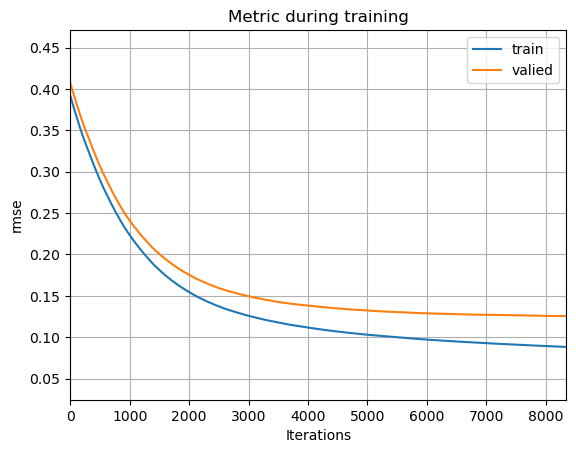

In [23]:
eval_set = [(X_valied, y_valied), (X_train, y_train)]
eval_name = ['valied', 'train']
callbacks = []
callbacks.append(lgb.early_stopping(stopping_rounds=50, verbose=False))

fit_params = {"eval_metric":"rmse", 
              "eval_set":eval_set, 
              "eval_names":eval_name,
              "callbacks":callbacks,
              }
             
best_params = {'max_depth': 5, 
               'colsample_bytree': 0.4, 
               'min_child_samples': 2, 
               'num_leaves': 6, 
               'reg_alpha': 0.0001, 
               'reg_lambda': 0.0001, 
               'subsample': 0.4, 
               'subsample_freq': 7
               }

model_lgb_best = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', metric='rmse',
                      random_state=42, n_estimators=20000, importance_type='gain', learning_rate=0.001, **best_params)
model_lgb_best = train_and_valied(model=model_lgb_best, X_train=X_train, y_train=y_train, X_test=X_valied, y_test=y_valied, aditional_kwargs=fit_params)
lgb.plot_metric(model_lgb_best)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

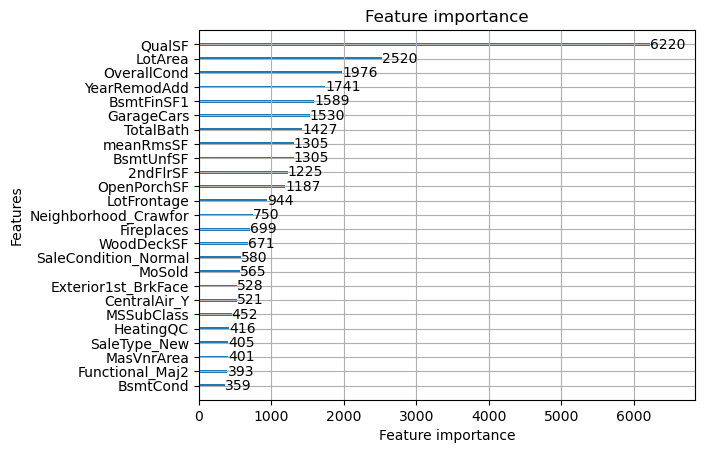

In [24]:
lgb.plot_importance(model_lgb_best, max_num_features=25)

#### 2.3.1.2.スケール変換なし

LotArea meanRmsSF TotalBath SalePrice MasVnrArea LotFrontage QualSF [1]	train's rmse: 0.389157	valied's rmse: 0.404328
[2]	train's rmse: 0.386992	valied's rmse: 0.402396
[3]	train's rmse: 0.383973	valied's rmse: 0.399281
[4]	train's rmse: 0.381025	valied's rmse: 0.396208
[5]	train's rmse: 0.378027	valied's rmse: 0.393148
[6]	train's rmse: 0.375809	valied's rmse: 0.390903
[7]	train's rmse: 0.373557	valied's rmse: 0.388608
[8]	train's rmse: 0.370736	valied's rmse: 0.385694
[9]	train's rmse: 0.368648	valied's rmse: 0.383695
[10]	train's rmse: 0.365884	valied's rmse: 0.380839
[11]	train's rmse: 0.363095	valied's rmse: 0.378024
[12]	train's rmse: 0.360401	valied's rmse: 0.37524
[13]	train's rmse: 0.358459	valied's rmse: 0.373291
[14]	train's rmse: 0.356343	valied's rmse: 0.37129
[15]	train's rmse: 0.354419	valied's rmse: 0.369358
[16]	train's rmse: 0.352449	valied's rmse: 0.367301
[17]	train's rmse: 0.349791	valied's rmse: 0.364576
[18]	train's rmse: 0.348219	valied's rmse: 0.362804
[19]	tr

z:\miyata\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
z:\miyata\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[137]	train's rmse: 0.188257	valied's rmse: 0.206289
[138]	train's rmse: 0.187625	valied's rmse: 0.205614
[139]	train's rmse: 0.186967	valied's rmse: 0.205039
[140]	train's rmse: 0.186035	valied's rmse: 0.204143
[141]	train's rmse: 0.185125	valied's rmse: 0.20327
[142]	train's rmse: 0.184494	valied's rmse: 0.202725
[143]	train's rmse: 0.183834	valied's rmse: 0.202189
[144]	train's rmse: 0.183256	valied's rmse: 0.201691
[145]	train's rmse: 0.182626	valied's rmse: 0.201081
[146]	train's rmse: 0.181987	valied's rmse: 0.200449
[147]	train's rmse: 0.18114	valied's rmse: 0.19963
[148]	train's rmse: 0.180531	valied's rmse: 0.199082
[149]	train's rmse: 0.18007	valied's rmse: 0.198752
[150]	train's rmse: 0.179271	valied's rmse: 0.197981
[151]	train's rmse: 0.178717	valied's rmse: 0.197541
[152]	train's rmse: 0.177939	valied's rmse: 0.196789
[153]	train's rmse: 0.177326	valied's rmse: 0.19621
[154]	train's rmse: 0.176581	valied's rmse: 0.19549
[155]	train's rmse: 0.176027	valied's rmse: 0.195059

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

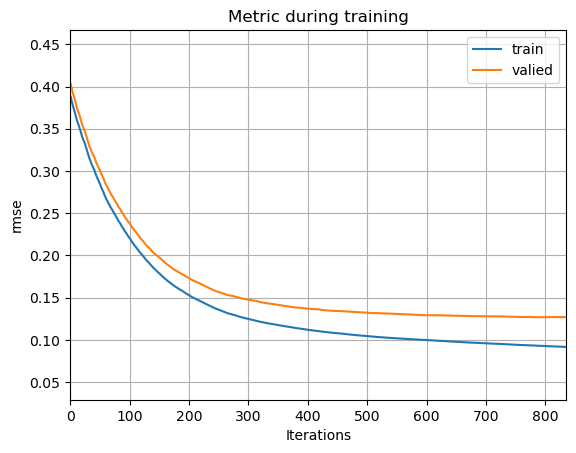

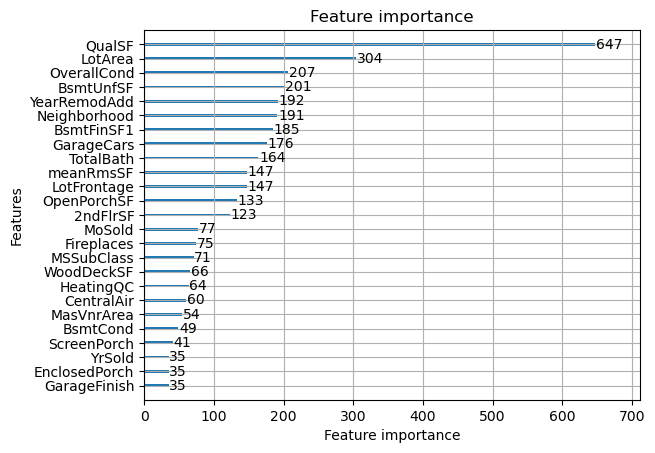

In [25]:
train_data_raw = EDA(pd.read_csv("./data/train.csv", index_col=0, decimal=","))
train_data = EDA(pd.read_csv("./data/train_after_EDA.csv", index_col=0, decimal=","))
test_data = EDA(pd.read_csv("./data/test_after_EDA.csv", index_col=0, decimal=","))

# なぜか文字列として読み込まれてしまう特徴量を型変換
after = set(train_data.categorical_feature.columns)
before = set(train_data_raw.categorical_feature.columns)
diff_feature = after-before
for name in diff_feature:
    print(name, end="  \b")
    if name == "SalePrice":
        train_data.data[name] = train_data.data[name].astype(float)
    else:
        train_data.data[name] = train_data.data[name].astype(float)
        test_data.data[name] = test_data.data[name].astype(float)
        
train_data.set_categorical_and_numerical_feature()
test_data.set_categorical_and_numerical_feature()
categorical_featre = train_data.categorical_feature.columns
train_data.data.loc[:, categorical_featre] = train_data.data.loc[:, categorical_featre].astype('category')
test_data.data.loc[:, categorical_featre] = test_data.data.loc[:, categorical_featre].astype('category')

X = deepcopy(train_data.data.drop('SalePrice', axis=1))
y = train_data.data['SalePrice']

X_train, X_valied, y_train, y_valied = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = test_data.data

# temp = EDA(X_train)
# categorical_featre = temp.set_categorical_and_numerical_feature()

model_pram = {'max_depth': 5, 
               'colsample_bytree': 0.4, 
               'min_child_samples': 2, 
               'num_leaves': 6, 
               'reg_alpha': 0.0001, 
               'reg_lambda': 0.0001, 
               'subsample': 0.4, 
               'subsample_freq': 7
               }

eval_set = [(X_valied, y_valied), (X_train, y_train)]
eval_name = ['valied', 'train']
callbacks = []
callbacks.append(lgb.early_stopping(stopping_rounds=50, verbose=False))

fit_params = {"eval_metric":"rmse", 
              "eval_set":eval_set, 
              "eval_names":eval_name,
              "callbacks":callbacks,
              #"categorical_feature": categorical_featre,
              }

model_lgb_best = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', metric='rmse',
                      random_state=42, n_estimators=10000, importance_type='gain', learning_rate=0.01, **model_pram)

model_lgb_best = train_and_valied(model=model_lgb_best, X_train=X_train, y_train=y_train, X_test=X_valied, y_test=y_valied, aditional_kwargs=fit_params)
lgb.plot_metric(model_lgb_best)
lgb.plot_importance(model_lgb_best, max_num_features=25)

### 2.3.2. XGboost

In [6]:
xgb_params = {'booster': 'gbtree',
              'n_estimators': 2000, 
              'max_depth': 3, 
              'learning_rate': 0.001, 
              'gamma': 0.0001, 
              'reg_alpha': 0.0001, 
              'reg_lambda': 0.0001, 
              'subsample': 0.3, 
              'colsample_bytree': 0.3,
              'n_jobs' : -1,
              'eval_metric': "rmse",
              'early_stopping_rounds' :100,
            }

cv_xgb_params = {'booster': ['gbtree'],
              'n_estimators': [15000], 
              'max_depth': [3], 
              'learning_rate': [0.01], 
              'gamma': [0.0001], #決定木の葉の追加による損失減少の下限(小さいほど過学習寄り)
              'reg_alpha': [0.0001, 0.001], #決定木の葉の重みに関するL1正則化項(小さいほど過学習寄り)
              'reg_lambda': [0.0001, 0.001], #決定木の葉の重みに関するL2正則化項(小さいほど過学習寄り)
              'subsample': [0.3, 0.5], #各決定木においてランダムに抽出される標本の割合(大きいほど過学習寄り)
              'colsample_bytree': [0.3, 0.5, 0.7], #各決定木においてランダムに抽出される列（特徴量）の割合
              'n_jobs' : [-1],
              'eval_metric': ["rmse"],
              'early_stopping_rounds' :[10],
            }            

fit_params = {
              "eval_set":[(X_valied, y_valied)], 
              'verbose' : False
              #"eval_names":['valied', 'train'],
              #"callbacks":callbacks,
              #"categorical_feature": categorical_featre,
              }
              
# model_xgb = XGBRegressor(**xgb_params)
cv_xgb = GridSearchCV(estimator=XGBRegressor(), param_grid=cv_xgb_params, n_jobs=-1, scoring="neg_mean_squared_error", cv=3)
cv_xgb = train_and_valied(model=cv_xgb, X_train=X_train, y_train=y_train, X_test=X_valied, y_test=y_valied, aditional_kwargs=fit_params)
print(f"best params -> {cv_xgb.best_params_}")   
display(pd.DataFrame(cv_xgb.cv_results_))
# model_xgb = train_and_valied(model=model_xgb, X_train=X_train, y_train=y_train, X_test=X_valied, y_test=y_valied, aditional_kwargs=fit_params)
# plot_importance(model_xgb, max_num_features=20)

RMSE : 0.1254
best params -> {'booster': 'gbtree', 'colsample_bytree': 0.5, 'early_stopping_rounds': 10, 'eval_metric': 'rmse', 'gamma': 0.0001, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 15000, 'n_jobs': -1, 'reg_alpha': 0.0001, 'reg_lambda': 0.0001, 'subsample': 0.3}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_booster,param_colsample_bytree,param_early_stopping_rounds,param_eval_metric,param_gamma,param_learning_rate,...,param_reg_alpha,param_reg_lambda,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,3.69,0.07,0.02,1.39e-03,gbtree,0.3,10,rmse,0.0,0.01,...,0.0,0.0,0.3,"{'booster': 'gbtree', 'colsample_bytree': 0.3,...",-0.02,-0.02,-0.01,-0.02,1.32e-03,14
1,4.09,0.19,0.02,8.87e-04,gbtree,0.3,10,rmse,0.0,0.01,...,0.0,0.0,0.5,"{'booster': 'gbtree', 'colsample_bytree': 0.3,...",-0.02,-0.02,-0.01,-0.02,1.53e-03,18
2,3.63,0.12,0.02,2.55e-03,gbtree,0.3,10,rmse,0.0,0.01,...,0.0,0.0,0.3,"{'booster': 'gbtree', 'colsample_bytree': 0.3,...",-0.02,-0.02,-0.01,-0.02,1.34e-03,21
3,4.18,0.19,0.02,6.32e-04,gbtree,0.3,10,rmse,0.0,0.01,...,0.0,0.0,0.5,"{'booster': 'gbtree', 'colsample_bytree': 0.3,...",-0.02,-0.02,-0.01,-0.02,1.44e-03,12
4,3.38,0.17,0.02,7.93e-04,gbtree,0.3,10,rmse,0.0,0.01,...,0.0,0.0,0.3,"{'booster': 'gbtree', 'colsample_bytree': 0.3,...",-0.02,-0.02,-0.01,-0.02,1.53e-03,24
5,4.10,0.11,0.02,1.94e-03,gbtree,0.3,10,rmse,0.0,0.01,...,0.0,0.0,0.5,"{'booster': 'gbtree', 'colsample_bytree': 0.3,...",-0.02,-0.02,-0.01,-0.02,1.48e-03,13
6,3.64,0.07,0.02,8.46e-04,gbtree,0.3,10,rmse,0.0,0.01,...,0.0,0.0,0.3,"{'booster': 'gbtree', 'colsample_bytree': 0.3,...",-0.02,-0.02,-0.01,-0.02,1.33e-03,17
7,4.42,0.29,0.02,5.82e-04,gbtree,0.3,10,rmse,0.0,0.01,...,0.0,0.0,0.5,"{'booster': 'gbtree', 'colsample_bytree': 0.3,...",-0.02,-0.02,-0.01,-0.02,1.40e-03,11
8,4.07,0.25,0.02,1.73e-03,gbtree,0.5,10,rmse,0.0,0.01,...,0.0,0.0,0.3,"{'booster': 'gbtree', 'colsample_bytree': 0.5,...",-0.02,-0.02,-0.01,-0.01,1.72e-03,1
9,4.75,0.30,0.02,3.06e-04,gbtree,0.5,10,rmse,0.0,0.01,...,0.0,0.0,0.5,"{'booster': 'gbtree', 'colsample_bytree': 0.5,...",-0.02,-0.02,-0.01,-0.02,1.52e-03,2


### 2.3.3.RandomForest

In [43]:

parameters = {  
    'n_estimators': [100],     # 用意する決定木モデルの数
    'max_features': [None],  # ランダムに指定する特徴量の数
    'max_depth': [20, 50, 100],     # 決定木のノード深さの制限値
    'min_samples_split': [3]
    
}

# モデルインスタンス
model_randomforest = RandomForestRegressor(n_jobs=-1)

# ハイパーパラメータチューニング(グリッドサーチのコンストラクタにモデルと辞書パラメータを指定)
gridsearch = GridSearchCV(estimator = model_randomforest,        # モデル
                          param_grid = parameters,  # チューニングするハイパーパラメータ
                          scoring = "neg_mean_squared_error", # スコアリング
                          cv=5
                         )
model_randomforest = train_and_valied(model=gridsearch, X_train=X_train, y_train=y_train,
                                        X_test=X_valied, y_test=y_valied, scoring="RMSE")

RMSE : 0.1429


In [44]:
model_randomforest.best_params_

{'max_depth': 50,
 'max_features': None,
 'min_samples_split': 3,
 'n_estimators': 100}

In [45]:
result_df = pd.DataFrame(gridsearch.cv_results_)
display(result_df)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.10,2.06,0.05,5.48e-03,20,None,3,100,"{'max_depth': 20, 'max_features': None, 'min_s...",-0.02,-0.02,-0.02,-0.02,-0.02,-0.02,1.90e-03,2
1,1.06,0.02,0.04,1.29e-02,50,None,3,100,"{'max_depth': 50, 'max_features': None, 'min_s...",-0.02,-0.02,-0.02,-0.02,-0.02,-0.02,1.66e-03,1
2,1.04,0.01,0.04,1.61e-03,100,None,3,100,"{'max_depth': 100, 'max_features': None, 'min_...",-0.02,-0.02,-0.02,-0.02,-0.02,-0.02,1.76e-03,3


# 3.Stacking

In [34]:
# ========================1層目モデル===========================================================
# (1) Lasso
lasso_params ={'alpha': 0.001,
               'random_state': 42,
               'selection': 'random',
                }
model_lasso = Lasso(**lasso_params)

# (2) SVR
svr_params = {'C': 0.2, 'epsilon': 0.03, 'kernel': 'linear'}
model_svr = SVR(**svr_params)

# (3) LighGBM
callbacks = []
callbacks.append(lgb.early_stopping(stopping_rounds=50, verbose=False))

lgb_fit_params = {"eval_metric":"rmse", 
              "eval_set":[(X_valied, y_valied), (X_train, y_train)], 
              "eval_names":['valied', 'train'],
              "callbacks":callbacks,
              }
             
best_params = {'colsample_bytree': 0.4, 
               'min_child_samples': 2, 
               'num_leaves': 6, 
               'reg_alpha': 0.0001, 
               'reg_lambda': 0.0001, 
               'subsample': 0.4, 
               'subsample_freq': 7
               }

model_lgb = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', metric='rmse',
                      random_state=42, n_estimators=3000, importance_type='gain', learning_rate=0.01, verbosity=-1, **best_params)

# (4) RandomForest
rdf_params = {  
    'n_estimators': 100,     # 用意する決定木モデルの数
    'max_features': None,  # ランダムに指定する特徴量の数
    'max_depth': 50,     # 決定木のノード深さの制限値
    'min_samples_split': 3
    
}

model_randomforest = RandomForestRegressor(n_jobs=-1, **rdf_params)

# (5) XGBoost
xgb_params = {'booster': 'gbtree', 'colsample_bytree': 0.5, 
                'early_stopping_rounds': 10, 'eval_metric': 'rmse', 
                'gamma': 0.0001, 'learning_rate': 0.01, 'max_depth': 3, 
                'n_estimators': 15000, 'n_jobs': -1, 'reg_alpha': 0.0001, 
                'reg_lambda': 0.0001, 'subsample': 0.3}

xgb_fit_params = {
              "eval_set":[(X_valied, y_valied)], 
              'verbose' : False
              }

model_xgb = XGBRegressor(**xgb_params)
# =======================2層目モデル===========================================================
ridge_params = {'alpha': 1.,
                'random_state': 42,
                }
model_ridge = Ridge(**ridge_params)

# ======================スタッキングセット======================================================

first_layer = {
    "Lasso": [model_lasso, {}],
    "SVR": [model_svr, {}],
    "LighGBM": [model_lgb, lgb_fit_params], #lgb_fit_params
    "RandomForest": [model_randomforest, {}],
    "XGBoost": [model_xgb, xgb_fit_params]
}

second_layer = {
    "Ridge": [model_ridge, {}],
}

stacking(first_layer_models=first_layer,
         second_lyaer_models=second_layer,
         X_train=X_train, y_train=y_train,
         X_test=X_valied, y_test=y_valied, cv=5)

first_layer model_0 -> Lasso
Lasso: RMSE -> 0.122

first_layer model_1 -> SVR
SVR: RMSE -> 0.121

first_layer model_2 -> LighGBM
[1]	valied's rmse: 0.406644	train's rmse: 0.390112
[2]	valied's rmse: 0.404579	train's rmse: 0.387981
[3]	valied's rmse: 0.401628	train's rmse: 0.385043
[4]	valied's rmse: 0.399522	train's rmse: 0.383049
[5]	valied's rmse: 0.39735	train's rmse: 0.380846
[6]	valied's rmse: 0.39542	train's rmse: 0.378992
[7]	valied's rmse: 0.393328	train's rmse: 0.376849
[8]	valied's rmse: 0.390978	train's rmse: 0.374647
[9]	valied's rmse: 0.388868	train's rmse: 0.37242
[10]	valied's rmse: 0.385798	train's rmse: 0.369392
[11]	valied's rmse: 0.382768	train's rmse: 0.366402
[12]	valied's rmse: 0.379784	train's rmse: 0.363414
[13]	valied's rmse: 0.377651	train's rmse: 0.361224
[14]	valied's rmse: 0.375725	train's rmse: 0.359208
[15]	valied's rmse: 0.373649	train's rmse: 0.357147
[16]	valied's rmse: 0.370824	train's rmse: 0.354373
[17]	valied's rmse: 0.368996	train's rmse: 0.35254


# 4.Blending

In [36]:
# ========================ブレンディングモデル===========================================================
# (1) Lasso
lasso_params ={'alpha': 0.001,
               'random_state': 42,
               'selection': 'random',
                }
model_lasso = Lasso(**lasso_params)

# (2) SVR
svr_params = {'C': 0.2, 'epsilon': 0.03, 'kernel': 'linear'}
model_svr = SVR(**svr_params)

# (3) LighGBM
callbacks = []
callbacks.append(lgb.early_stopping(stopping_rounds=50, verbose=False))

lgb_fit_params = {"eval_metric":"rmse", 
              "eval_set":[(X_valied, y_valied), (X_train, y_train)], 
              "eval_names":['valied', 'train'],
              "callbacks":callbacks,
              }
             
best_params = {'colsample_bytree': 0.4, 
               'min_child_samples': 2, 
               'num_leaves': 6, 
               'reg_alpha': 0.0001, 
               'reg_lambda': 0.0001, 
               'subsample': 0.4, 
               'subsample_freq': 7
               }

model_lgb = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', metric='rmse',
                      random_state=42, n_estimators=3000, importance_type='gain', learning_rate=0.01, verbosity=-1, **best_params)

# (4) RandomForest
rdf_params = {  
    'n_estimators': 100,     # 用意する決定木モデルの数
    'max_features': None,  # ランダムに指定する特徴量の数
    'max_depth': 50,     # 決定木のノード深さの制限値
    'min_samples_split': 3
    
}

model_randomforest = RandomForestRegressor(n_jobs=-1, **rdf_params)

# (5) XGBoost
xgb_params = {'booster': 'gbtree', 'colsample_bytree': 0.5, 
                'early_stopping_rounds': 10, 'eval_metric': 'rmse', 
                'gamma': 0.0001, 'learning_rate': 0.01, 'max_depth': 3, 
                'n_estimators': 15000, 'n_jobs': -1, 'reg_alpha': 0.0001, 
                'reg_lambda': 0.0001, 'subsample': 0.3}

xgb_fit_params = {
              "eval_set":[(X_valied, y_valied)], 
              'verbose' : False
              }

model_xgb = XGBRegressor(**xgb_params)

# (6) Ridge
ridge_params = {'alpha': 1.,
                'random_state': 42,
                }
model_ridge = Ridge(**ridge_params)

# ======================ブレンディングセット======================================================

blending_models = {
    "Lasso": [model_lasso, {}],
    "SVR": [model_svr, {}],
    "LighGBM": [model_lgb, lgb_fit_params], #lgb_fit_params
    "RandomForest": [model_randomforest, {}],
    # "XGBoost": [model_xgb, xgb_fit_params],
    "Ridge": [model_ridge, {}],
}

blending_rates = [0.2, 0.1, 0.3, 0.1, 0.3]
blender_model = Blender(blending_models=blending_models, blendig_rates=blending_rates)
blender_model = train_and_valied(model=blender_model, X_train=X_train, y_train=y_train, X_test=X_valied, y_test=y_valied)

fit Lasso
fit SVR
fit LighGBM
[1]	train's rmse: 0.38985	valied's rmse: 0.405298
[2]	train's rmse: 0.386826	valied's rmse: 0.402176
[3]	train's rmse: 0.384788	valied's rmse: 0.40018
[4]	train's rmse: 0.381787	valied's rmse: 0.397085
[5]	train's rmse: 0.379626	valied's rmse: 0.394841
[6]	train's rmse: 0.376716	valied's rmse: 0.391808
[7]	train's rmse: 0.373843	valied's rmse: 0.388812
[8]	train's rmse: 0.371022	valied's rmse: 0.385898
[9]	train's rmse: 0.368237	valied's rmse: 0.383021
[10]	train's rmse: 0.366142	valied's rmse: 0.380967
[11]	train's rmse: 0.364164	valied's rmse: 0.378983
[12]	train's rmse: 0.362098	valied's rmse: 0.37706
[13]	train's rmse: 0.360136	valied's rmse: 0.37516
[14]	train's rmse: 0.358367	valied's rmse: 0.373371
[15]	train's rmse: 0.355629	valied's rmse: 0.370563
[16]	train's rmse: 0.354109	valied's rmse: 0.369029
[17]	train's rmse: 0.352252	valied's rmse: 0.367176
[18]	train's rmse: 0.349616	valied's rmse: 0.36451
[19]	train's rmse: 0.347696	valied's rmse: 0.362

## 4.1 テストセット予測

In [37]:
y_test = np.expm1(blender_model.predict(X_test))
y_test = pd.Series(y_test, index=X_test.index, name='SalePrice')

dt_now = datetime.datetime.now().strftime(f'%Y-%m-%d-%H_%M')
print(dt_now)
fpath = f'./submission/submission_{dt_now}_.csv'
y_test.to_csv(fpath)

2023-02-17-17_12
